In [1]:
import tensorflow as tf

train_dir = 'data/train'
test_dir  = 'data/test'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 5200 files belonging to 2 classes.
Found 1416 files belonging to 2 classes.


{'Fraud': 200, 'Non-Fraud': 5000}


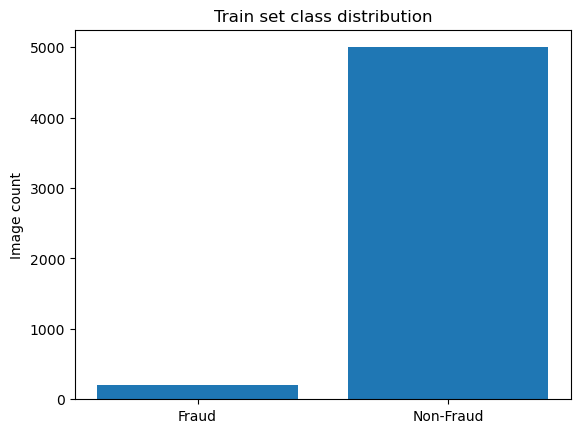

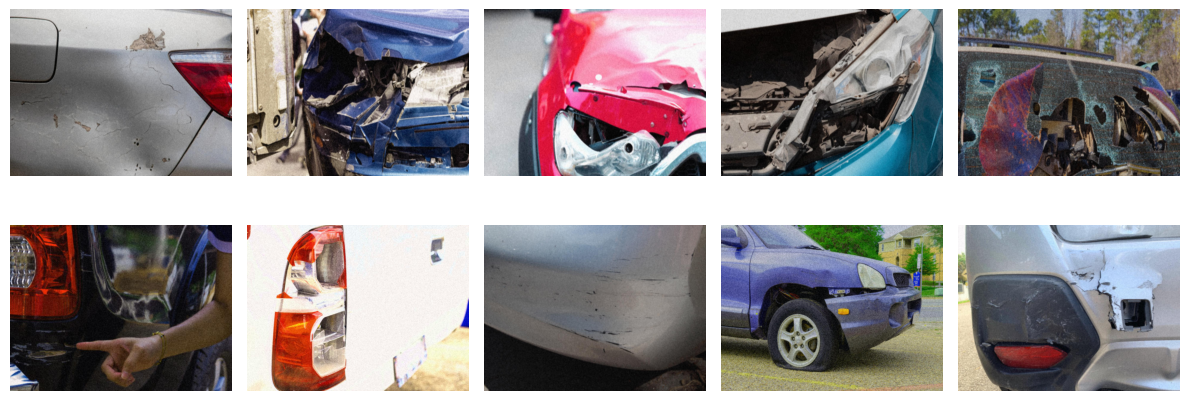

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import datasets
import random

raw_train = datasets.ImageFolder('data/train')
labels = [y for _,y in raw_train.imgs]

class_counts = Counter(labels)
print({raw_train.classes[k]: v for k,v in class_counts.items()})

plt.bar(raw_train.classes, [class_counts[i] for i in range(len(raw_train.classes))])
plt.title("Train set class distribution")
plt.ylabel("Image count")
plt.show()

fig, axs = plt.subplots(len(raw_train.classes), 5, figsize=(12, 5))
for i, cls in enumerate(raw_train.classes):
    imgs = [path for path, label in raw_train.samples if label == i]
    for j, path in enumerate(random.sample(imgs, 5)):
        img = plt.imread(path)
        ax = axs[i, j]
        ax.imshow(img)
        ax.axis('off')
        if j == 0:
            ax.set_ylabel(cls, rotation=0, labelpad=40)
plt.tight_layout()
plt.show()

In [ ]:
from torchvision import transforms

mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                           saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

train_ds = ImageFolder('data/train', transform=train_tfms)
val_ds   = ImageFolder('data/test',  transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)

In [12]:
import torch
import numpy as np
from torch.utils.data import WeightedRandomSampler

counts = np.bincount([y for _,y in train_ds.samples])
class_weights = 1. / counts
sample_weights = [class_weights[y] for _,y in train_ds.samples]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)

In [13]:
import sys
!{sys.executable} -m pip install --upgrade torch torchvision torchaudio optuna

  Using cached torchaudio-2.8.0-cp313-cp313-win_amd64.whl.metadata (7.2 kB)
Using cached torchaudio-2.8.0-cp313-cp313-win_amd64.whl (2.5 MB)

   ------------- -------------------------- 1/3 [torchaudio]
   ------------- -------------------------- 1/3 [torchaudio]
   -------------------------- ------------- 2/3 [optuna]
   -------------------------- ------------- 2/3 [optuna]
   ---------------------------------------- 3/3 [optuna]



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import f1_score
import numpy as np
import optuna

class TunableNet(nn.Module):
    def __init__(self, dropout_rate, pretrained=True):
        super().__init__()
        backbone = models.efficientnet_b0(pretrained=pretrained)
        in_f = backbone.classifier[1].in_features
        backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_f, 2)
        )
        self.net = backbone

    def forward(self, x):
        return self.net(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):
   
    lr           = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    dropout      = trial.suggest_float("dropout_rate", 0.1, 0.7)
    batch_size   = trial.suggest_categorical("batch_size", [16, 32, 64])

    train_loader = DataLoader(
        train_ds,
        sampler=sampler,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    model = TunableNet(dropout).to(device)
    w = torch.tensor(class_weights, dtype=torch.float32, device=device)
    criterion = nn.CrossEntropyLoss(weight=w)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(3):
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optimizer.step()

    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            preds.extend(logits.argmax(1).cpu().numpy())
            trues.extend(y.cpu().numpy())

    return f1_score(trues, preds, pos_label=1)

In [20]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50)

    print("📈 Best F1    :", study.best_value)
    print("🔧 Best params:", study.best_params)

[I 2025-08-07 06:33:49,739] A new study created in memory with name: no-name-104931a1-3d0b-4e40-91df-a19e88b57108
[I 2025-08-07 06:42:56,702] Trial 0 finished with value: 0.6332644628099173 and parameters: {'lr': 2.227646134653828e-05, 'weight_decay': 1.2868276782710959e-05, 'dropout_rate': 0.3177522954563987, 'batch_size': 16}. Best is trial 0 with value: 0.6332644628099173.
c:\Users\zhang\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zhang\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.

📈 Best F1    : 0.967741935483871
🔧 Best params: {'lr': 0.0002505980177928082, 'weight_decay': 7.586040790105609e-06, 'dropout_rate': 0.6146545795722145, 'batch_size': 32}
